<div class="alert alert-block alert-info">
<b>Import libraries and setup </b>
</div>

In [1]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# Enable inline plotting for notebooks
%matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
n_epochs = 3
batch_size = 64
n_classes = 10

# Directory for storing npz data
npz_dir = './npz_data/'
os.makedirs(npz_dir, exist_ok=True)

<div class="alert alert-block alert-info">
<b> Model selection </b>
</div>

In [3]:
# To select other pretrained models, see the necessary configurations
# on this website: https://pytorch.org/vision/0.8/models.html

class ModelManager(nn.Module):
    def __init__(self, model_name, in_channels=1, out_classes=10):
        super().__init__()

        self.model_dict = {'ResNet': models.resnet18, 'VGG': models.vgg16}
        base_model = self.model_dict.get(model_name)

        if base_model is None:
            raise ValueError("Invalid model name")

        self.model = base_model(pretrained=True)

        # Optional: Change input layer for grayscale images
        # self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # update the output layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, out_classes)

    def forward(self, x):
        return self.model(x)

<div class="alert alert-block alert-info">
<b> Dataset selection </b>
</div>

In [4]:
#To select other datasets, see the necessary configurations
# on this website: https://pytorch.org/vision/stable/datasets.html

class CustomDataset(Dataset):
    def __init__(self, dataset_dir, dataset_name, train=True, transform=None):
        dataset_function = getattr(datasets, dataset_name, None)

        if dataset_function is None:
            raise ValueError(f"Invalid dataset name: {dataset_name}")

        self.dataset = dataset_function(root=dataset_dir, train=train, download=True)
        self.labels = self.dataset.targets
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]
        transformed_data = self.transform(data) if self.transform else data
        return index, transformed_data, target

    def display(self, index):
        data, target = self.dataset[index]
        print(f"Image label: {target}")
        plt.axis('off')
        plt.imshow(data, cmap='gray')
        plt.show()

<div class="alert alert-block alert-info">
<b> Training and test phases</b>
</div>

In [5]:
class Manager:
    def __init__(self, model, train_loader, test_loader, optimizer, criterion, device):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.train_predictions = np.zeros(len(self.train_loader.dataset))
        self.test_predictions = []
        self.train_logits = None
        self.test_logits = None
        self.deepgini_scores = []
        self.misclassified_indices = []

    def train(self, epoch):

        self.model.train()
        total_train_loss = 0
        correct_predictions = 0
        penultimate_output = torch.zeros(n_classes,len(self.train_loader.dataset))

        for indices, inputs, targets in tqdm(self.train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            logits = self.model(inputs)

            # Zero out gradients from previous iteration
            self.optimizer.zero_grad()
            predicted_probs = torch.softmax(logits, dim=1)
            loss = self.criterion(logits, targets)

            # Backward pass and optimization
            loss.backward()
            self.optimizer.step()
            total_train_loss += loss.item()

            # Identify the predicted classes and update correct count
            prediction = predicted_probs.argmax(dim=1, keepdim=True).squeeze()
            is_correct = (prediction == targets.view_as(prediction))
            self.train_predictions[indices.tolist()] = prediction.tolist()
            penultimate_output[:, indices] = logits.T.data.cpu().detach()

            correct_predictions += is_correct.sum().item()

        # Calculate and display training metrics
        self.train_logits = penultimate_output.numpy()
        total_train_loss /= len(self.train_loader.dataset)
        train_accuracy = 100.0 * correct_predictions / len(self.train_loader.dataset)
        print(f'\nTraining accuracy: {train_accuracy:.6f}%, loss: {total_train_loss:.6f}', end=",")



    def test(self):

        self.model.eval()

        test_loss = 0
        correct_count = 0
        correct_predictions = []
        penultimate_output = torch.zeros(n_classes,len(self.test_loader.dataset))

        # Disable gradient computation
        with torch.no_grad():

            for indices, inputs, targets in tqdm(self.test_loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass and prediction
                logits = self.model(inputs)
                predicted_probs = torch.softmax(logits, dim=1)

                test_loss += self.criterion(logits, targets).item()

                # Calculate deep Gini scores
                gini_scores = 1 - predicted_probs.square().sum(1).cpu().detach().numpy().round(decimals=3)
                self.deepgini_scores.extend(gini_scores)

                # Identify the predicted classes and update correct count
                prediction = predicted_probs.argmax(dim=1, keepdim=True).squeeze()
                self.test_predictions.extend(prediction.cpu().detach().numpy())
                is_correct = (prediction == targets.view_as(prediction))
                correct_predictions.extend(is_correct.tolist())
                correct_count += is_correct.sum().item()
                penultimate_output[:,indices] = logits.T.data.cpu().detach()

        # Identify misclassified instances and display test metrics
        self.test_logits = penultimate_output.numpy()
        self.misclassified_indices = np.where(np.array(correct_predictions) == False)[0]
        test_loss /= len(self.test_loader.dataset)
        test_accuracy = 100.0 * correct_count / len(self.test_loader.dataset)
        print(f'\nTesting accuracy: {test_accuracy:.6f}%, loss: {test_loss:.6f}')


    def run(self, n_epochs):
        for epoch in range(n_epochs):
            print(f"Epoch {epoch + 1}")
            self.train(epoch)
            self.test()

In [6]:
# Read the dataset name from the user
dataset_name = input('Enter the name of the dataset: ').strip()

# Create dataset directory and transformations
dataset_directory = os.path.join('Datasets', dataset_name)
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Initialize train and test datasets
train_dataset = CustomDataset(dataset_directory, dataset_name, train=True, transform=image_transforms)
test_dataset = CustomDataset(dataset_directory, dataset_name, train=False, transform=image_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(range(len(train_dataset))))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Enter the name of the dataset: CIFAR10


100%|██████████| 170498071/170498071 [00:05<00:00, 30692782.28it/s]


Extracting Datasets/CIFAR10/cifar-10-python.tar.gz to Datasets/CIFAR10
Files already downloaded and verified


In [7]:
# Create a model
model_name = input('Enter model name (ResNet/VGG): ').strip()
classifier = ModelManager(model_name)
print(f"Successfully created a {model_name} model.")

# Setup loss function
criterion = nn.CrossEntropyLoss()

# Determine the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier.to(device)

# Initialize optimizer
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

Enter model name (ResNet/VGG): ResNet


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 280MB/s]


Successfully created a ResNet model.


In [8]:
manager = Manager(model=classifier, train_loader=train_loader, test_loader=test_loader,
                          optimizer=optimizer, criterion=criterion, device=device)
manager.run(n_epochs)

Epoch 1


100%|██████████| 196/196 [01:39<00:00,  1.97it/s]



Training accuracy: 85.572000%, loss: 0.001652,

100%|██████████| 40/40 [00:09<00:00,  4.29it/s]

Testing accuracy: 82.920000%, loss: 0.002158


<div class="alert alert-block alert-info">
<b> Storing the data</b>
</div>

In [9]:
file_name = f'{dataset_name} - {model_name}.npz'

# Save data into a compressed NumPy file
np.savez(
    os.path.join(npz_dir, file_name),
    train=manager.train_logits,
    test=manager.test_logits,
    mis_test_indices = manager.misclassified_indices,
    train_pred_labels = manager.train_predictions,
    test_pred_labels = manager.test_predictions,
    train_gt_labels = train_dataset.labels,
    test_gt_labels = test_dataset.labels,
    gini_score = manager.deepgini_scores
)


<div class="alert alert-block alert-success">
<b> Visualize some samples</b>
</div>

Image label: 0


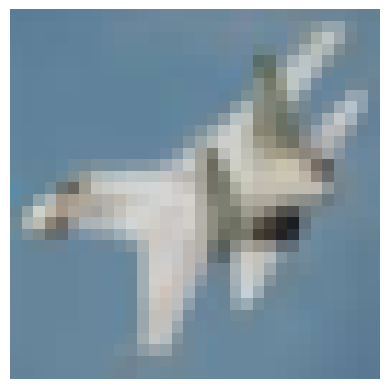

In [45]:
# Display a sample image with index 1500
test_dataset.display(10)

Image label: 9


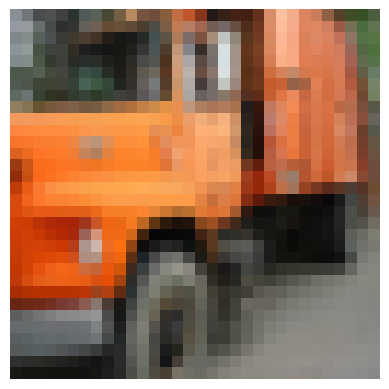

In [46]:
# Display a sample image with index 6666
train_dataset.display(6666)

In [24]:
# CIFAR10 classes
# {'airplane': 0,
# 'automobile': 1,
# 'bird': 2,
#  'cat': 3,
#  'deer': 4,
#  'dog': 5,
#  'frog': 6,
#  'horse': 7,
#  'ship': 8,
#  'truck': 9}

In [ ]:
# Alert: Training the neural network produces new weights and new high-level features.
# Thus, you might have new misclassified instances different from our results!